## This is not interactive kernel. Download it and check it on the downloaded data.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from sklearn import neighbors, linear_model
from sklearn.model_selection import train_test_split
from skimage.feature import greycomatrix, greycoprops
import cv2
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

In [4]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,8

In [5]:
img_width = 64
img_height = 64
train_root_folder = 'fibrosis_patches_png/train/'
test_root_folder = 'fibrosis_patches_png/test/'

In [7]:
df_files = pd.read_csv('train.csv')
df_files = df_files.sample(frac=1.0, random_state=42)
df_files.head()

,filename,class
16143,1a15bf60624e6ae27307ed2b63f68378.png,0
13660,6854cd6715a755b888c6e4cb366b81d9.png,0
344,c1c3feff2ca3ff7869a703aa3db228af.png,1
1034,ddd6eb7a79de1124fbdbe4bd0b10fcfb.png,1
8109,12a55627c1b72c77d16f3d7ee6bbc2ff.png,1


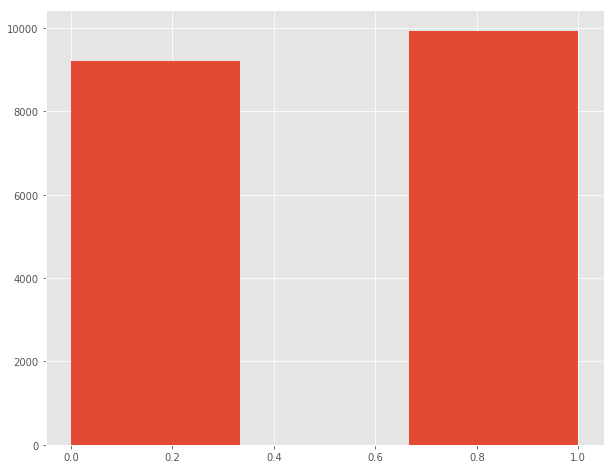

In [8]:
df_files['class'].hist(bins=3);

The dataset more or less balanced. Let's load it.

In [9]:
X = np.zeros((df_files.shape[0],img_width, img_height), dtype=np.uint8)
for idx,file in tqdm(enumerate(df_files['filename'])):
    X[idx] = cv2.imread(train_root_folder+file,0)

A Jupyter Widget

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

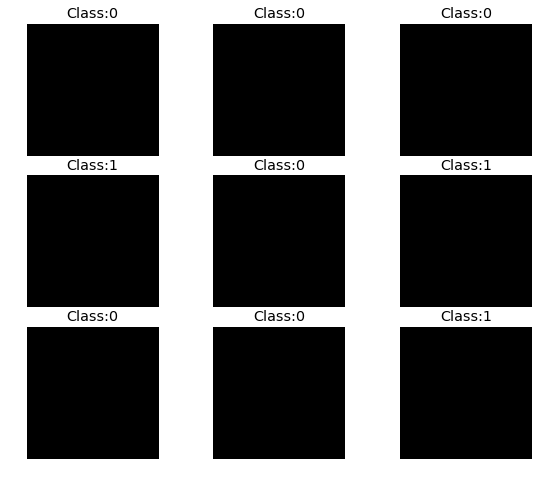

In [10]:
for i in range(9):
    plt.subplot(3,3,i+1)
    idx = np.random.randint(df_files.shape[0])
    plt.imshow(X[idx], cmap='bone')
    plt.title('Class:' + str(df_files.iloc[idx,1]))
    plt.grid('off')
    plt.axis('off')
plt.subplots_adjust(hspace=0.15, wspace=0.01)

As it can be noticed patches are visually inseparable. Let's split the dataset and extract some features from the both parts.

In [11]:
y = df_files['class']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
def calc_GLCM_features(X):
    GLCM_features = np.zeros((X.shape[0], 4), dtype=np.float32)
    for i in tqdm(range(X.shape[0])):
        img = X[i]
        glcm = greycomatrix(img, [2], [0], 256, symmetric=True, normed=True)
        GLCM_features[i] = np.array([greycoprops(glcm, 'dissimilarity')[0, 0],
                           greycoprops(glcm, 'correlation')[0, 0],
                           greycoprops(glcm, 'homogeneity')[0, 0],
                           greycoprops(glcm, 'contrast')[0, 0]])
    return GLCM_features

In [13]:
GLCM_train = calc_GLCM_features(X_train)
GLCM_val = calc_GLCM_features(X_val)

A Jupyter Widget

A Jupyter Widget

Let's take a look if extracted features are distinguishable. In some way yes, they are.

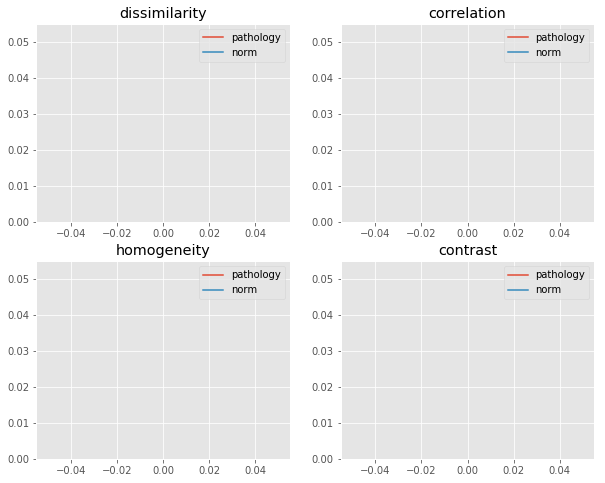

In [14]:
titles = ['dissimilarity', 'correlation' , 'homogeneity', 'contrast']
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.kdeplot(GLCM_train[y_train==1, i], label='pathology');
    sns.kdeplot(GLCM_train[y_train==0, i], label='norm');
    plt.title(titles[i]);

Let's plot the PCA projection to check if they are linearly separable.

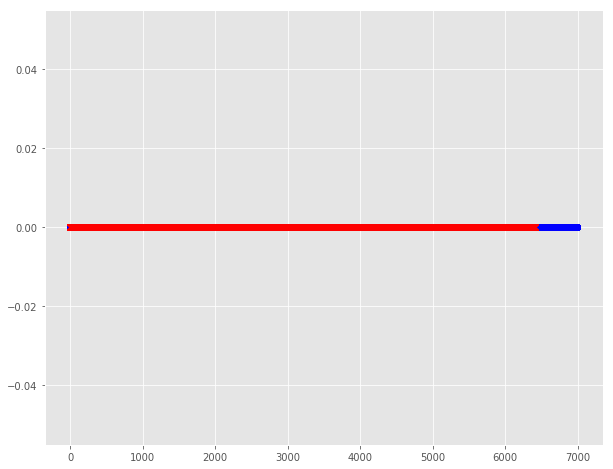

In [15]:
pca = PCA(n_components=2)
GLCM_pca = pca.fit_transform(GLCM_train)
plt.plot(GLCM_pca[y_train==1],'bo', label='pathology');
plt.plot(GLCM_pca[y_train==0],'rx', label='norm');

Not really. But it is a baseline, so let's build a linear classifier:)

In [16]:
knn = neighbors.KNeighborsClassifier()
logistic = linear_model.LogisticRegression()
print('KNN score: %f' % knn.fit(GLCM_train, y_train).score(GLCM_val, y_val))
print('LogisticRegression score: %f'
      % logistic.fit(GLCM_train, y_train).score(GLCM_val, y_val))

KNN score: 0.488518
LogisticRegression score: 0.511482


So the score is fine for the baseline model. Let's fit the logistic regression on the whole train set.

In [17]:
GLCM_X = calc_GLCM_features(X)
logistic.fit(GLCM_X, y)

A Jupyter Widget

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Now it is time to read the test file and to make predictions.

In [18]:
df_test = pd.read_csv('test.csv')
X_test = np.zeros((df_test.shape[0],img_width, img_height), dtype=np.uint8)
for idx,file in tqdm(enumerate(df_test['filename'])):
    X_test[idx] = cv2.imread(test_root_folder+file,0)
GLCM_test = calc_GLCM_features(X_test)

A Jupyter Widget

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [ ]:
predictions = logistic.predict(GLCM_test)
df_pred = pd.DataFrame(predictions, columns=['predictions'])
df_pred = pd.concat((df_test, df_pred), axis=1)

In [ ]:
df_files.head()

In [ ]:
df_pred.to_csv('sample_submission.csv', header=True, index=None)